In [7]:
from matplotlib import pyplot as plt
import os
import numpy as np
import json
from sklearn.linear_model import LinearRegression
import pandas as pd


file_dir = "/data03/sunyi/time_constrained_cot/outputs/1_10"
latency_path = "/home/sunyi/CoT/Time-Constrained-CoT/latency/0115"
model_list = [
    "Qwen/QwQ-32B-Preview",
    "Qwen/Qwen2.5-32B-Instruct", 
    "Qwen/Qwen2.5-14B-Instruct", 
    "Qwen/Qwen2.5-7B-Instruct", 
    "Qwen/Qwen2.5-3B-Instruct", 
    "Qwen/Qwen2.5-1.5B-Instruct",   
    "mistralai/Mistral-Small-Instruct-2409",
    "mistralai/Mistral-Nemo-Instruct-2407" ,
    "mistralai/Ministral-8B-Instruct-2410",
    "mistralai/Mathstral-7B-v0.1",
    "google/gemma-2-27b-it",
    "google/gemma-2-9b-it",
    "google/gemma-2-2b-it",
    "microsoft/phi-4",
    "microsoft/Phi-3-medium-128k-instruct",
    "microsoft/Phi-3-small-128k-instruct",
    "microsoft/Phi-3-mini-128k-instruct",
    "microsoft/Phi-3.5-mini-instruct",
]

In [8]:
PROMP_LIST = ["-sbs-hard", "-direct-hard", "-quick-hard", "-sbs", "-direct", "-quick", "-c2f", "-aav"]
# PROMP_LIST = ["-sbs-hard", "-sbs", "-c2f", "-kf", "-aav"]


MODEL_SERIES_MAP = {
    "Qwen/QwQ-32B-Preview": "qwen",
    "Qwen/Qwen2.5-32B-Instruct": "qwen",
    "Qwen/Qwen2.5-14B-Instruct": "qwen",
    "Qwen/Qwen2.5-7B-Instruct": "qwen",
    "Qwen/Qwen2.5-3B-Instruct": "qwen",
    "Qwen/Qwen2.5-1.5B-Instruct": "qwen",
    "google/gemma-2-2b-it": "gemma",
    "google/gemma-2-9b-it": "gemma",
    "google/gemma-2-27b-it": "gemma",
    "mistralai/Mathstral-7B-v0.1": "mistral",
    "mistralai/Ministral-8B-Instruct-2410": "mistral",
    "mistralai/Mistral-Nemo-Instruct-2407": "mistral",
    "mistralai/Mistral-Small-Instruct-2409": "mistral",
    "microsoft/phi-4": "phi4",
    "microsoft/Phi-3-medium-128k-instruct": "phi3medium",
    "microsoft/Phi-3-small-128k-instruct": "phi3small",
    "microsoft/Phi-3.5-mini-instruct": "phi3mini",
    "microsoft/Phi-3-mini-128k-instruct": "phi3mini",
}


MODEL_SERIES_PROMPT_TYPE_MAP = {
    "qwen": ["qwen" + prompt for prompt in PROMP_LIST],
    "mistral": ["mistral"+prompt for prompt in PROMP_LIST],
    "gemma": ["gemma"+prompt for prompt in PROMP_LIST],
    "phi3mini": ["phi3mini"+prompt for prompt in PROMP_LIST],
    "phi3small": ["phi3small"+prompt for prompt in PROMP_LIST],
    "phi3medium": ["phi3medium"+prompt for prompt in PROMP_LIST],
    "phi4": ["phi4"+prompt for prompt in PROMP_LIST],
}

In [9]:
def gen_budget_latency_list(budget, data_name, model, prompt_type):
    if budget < 0:
        return [-1]
    elif budget == 0:
        return [25]
    else:
        if model in ["Qwen/QwQ-32B-Preview", "Skywork/Skywork-o1-Open-Llama-3.1-8B", "PowerInfer/SmallThinker-3B-Preview"]:
            if data_name == "gsm8k":
                budget_list = []
                for i in range(25, 600, 25):
                    budget_list.append(i)
                for i in range(600, 1201, 50):
                    budget_list.append(i)
            elif data_name in ["math", "math500"]:
                budget_list = []
                for i in range(25, 600, 25):
                    budget_list.append(i)
                for i in range(600, 2401, 50):
                    budget_list.append(i)
        else:    
            if data_name == "gsm8k":
                budget_list = []
                for i in range(25, 601, 25):
                    budget_list.append(i)
                # for i in range(600, 1001, 50):
                #     budget_list.append(i)
            elif data_name in ["math", "math500"]:
                budget_list = []
                for i in range(25, 600, 25):
                    budget_list.append(i)
                for i in range(600, 1201, 50):
                    budget_list.append(i)
    
    if "hard" not in prompt_type:
        budget_list = [budget + 25 for budget in budget_list]
    
    tokens = np.array([128, 256, 512, 1024])
    file = model.split("/")[-1] + "_a800.csv"
    df = pd.read_csv(os.path.join(latency_path, file))
    latencies = df.iloc[0, 1:].values  # Extract latency values for the first row
    # Perform linear regression on the measured latency data
    linear_model = LinearRegression()
    tokens = tokens.reshape(-1, 1)
    linear_model.fit(tokens, latencies)
    print(f"File: {file} - Linear Fit: Slope = {linear_model.coef_[0]:.2f}, Intercept = {linear_model.intercept_:.2f}")
    print(f"File: {file} - R^2 Score: {linear_model.score(tokens, latencies):.2f}")
    # change budget_list into latency_list using the linear regression model
    budget_list = np.array(budget_list)
    budget_list = budget_list.reshape(-1, 1)
    latency_list = linear_model.predict(budget_list)
    budget_list = budget_list.reshape(1, -1)[0]
    latency_list = latency_list.reshape(1, -1)[0]

    if "hard" not in prompt_type:
        budget_list = [budget - 25 for budget in budget_list]
        
    return budget_list, latency_list

In [10]:
dataset = "math500"
something = "_-1_seed0_t0.0_s0_e-1"

In [11]:
from typing import Union, Any, Iterable
from pathlib import Path

def load_jsonl(file: Union[str, Path]) -> Iterable[Any]:
    with open(file, "r", encoding="utf-8") as f:
        for line in f:
            try:
                yield json.loads(line)
            except:
                print("Error in loading:", line)
                exit()

def get_accs(metric_path):
    with open(metric_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    acc = data["acc"]
    level_acc = data["level_acc"]
    subject_acc = data["subject_acc"]
    
    return acc, level_acc, subject_acc

In [12]:
model_acc_dicts = {}
model_level_acc_dicts = {}
model_subject_acc_dicts = {}
model_latency_dicts = {}

for model in model_list:
    model_acc_dict = {}
    model_level_acc_dict = {}
    model_subject_acc_dict = {}
    model_prompt_list = MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]
    for prompt_type in model_prompt_list:
        budget_list, latency_list = gen_budget_latency_list(1, dataset, model, prompt_type)
        acc_list = []
        level_acc_list = []
        subject_acc_list = []
        for budget in budget_list:
            file_name = "test_" + prompt_type + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path = os.path.join(file_dir, model, prompt_type, dataset, file_name)
            acc, level_acc, subject_acc = get_accs(file_path)
            acc_list.append(acc)
            level_acc_list.append(level_acc)
            subject_acc_list.append(subject_acc)
        model_acc_dict[prompt_type] = acc_list
        model_level_acc_dict[prompt_type] = level_acc_list
        model_subject_acc_dict[prompt_type] = subject_acc_list
    model_acc_dicts[model] = model_acc_dict
    model_level_acc_dicts[model] = model_level_acc_dict
    model_subject_acc_dicts[model] = model_subject_acc_dict
    model_latency_dicts[model] = latency_list

File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.45
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.45
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.45
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.45
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.45
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.45
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.45
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.45
File: QwQ-32B-Preview_a800.csv - R^2 Scor

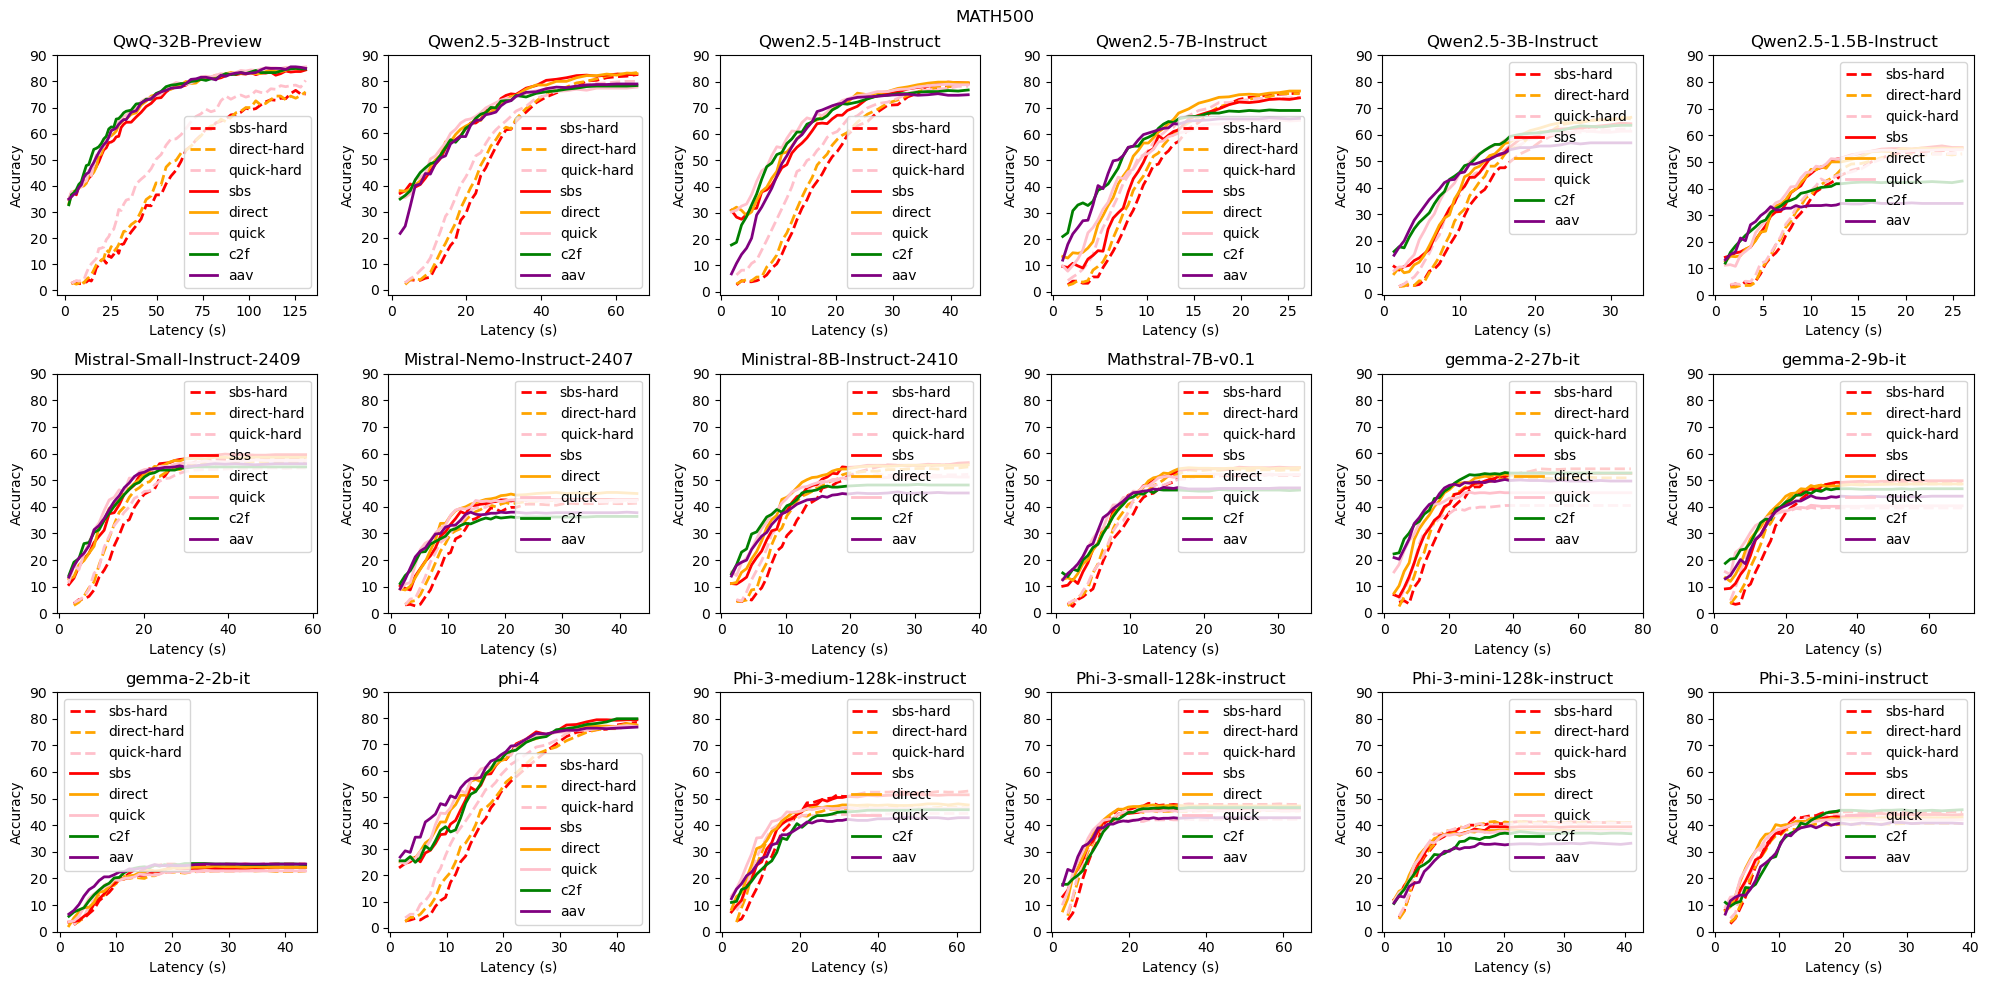

In [13]:
# Create a 2x3 subplot
fig, axs = plt.subplots(3, 6, figsize=(20, 10))
marker_size = 5  # Set the desired marker size
line_width = 2   # Set the desired line width

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot all lines first without labels
for index, model in enumerate(model_list):
    model_prompt_list = MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]
    for prompt_type in model_prompt_list:
        if "sbs-hard" in prompt_type:
            axs[index].plot(model_latency_dicts[model][1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="red", label="sbs-hard", linewidth=line_width)
        elif "direct-hard" in prompt_type:
            axs[index].plot(model_latency_dicts[model][1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="orange", label="direct-hard", linewidth=line_width)
        elif "quick-hard" in prompt_type:
            axs[index].plot(model_latency_dicts[model][1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="pink", label="quick-hard", linewidth=line_width)
        elif "sbs" in prompt_type:
            axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="red", label="sbs", linewidth=line_width)
        elif "direct" in prompt_type:
            axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="orange", label="direct", linewidth=line_width)
        elif "quick" in prompt_type:
            axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="pink", label="quick", linewidth=line_width)
        elif "c2f" in prompt_type:
            axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="green", label="c2f", linewidth=line_width)
        # elif "kf" in prompt_type:
        #     axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="blue", label="kf", linewidth=line_width)
        elif "aav" in prompt_type:
            axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="purple", label="aav", linewidth=line_width)
        axs[index].set_xlabel("Latency (s)")
        axs[index].set_ylabel("Accuracy")
        axs[index].set_title(f"{model.split('/')[-1]}")
        axs[index].legend()
        
        # Set y-axis and x-axis ticks
        axs[index].set_yticks(range(0, 91, 10))  # Set y-axis interval to 10
        # axs[index].set_xticks(range(0, 551, 50))  # Set x-axis interval to 50

# set the title
plt.suptitle(f"{dataset}".upper())
# Adjust layout
plt.tight_layout()

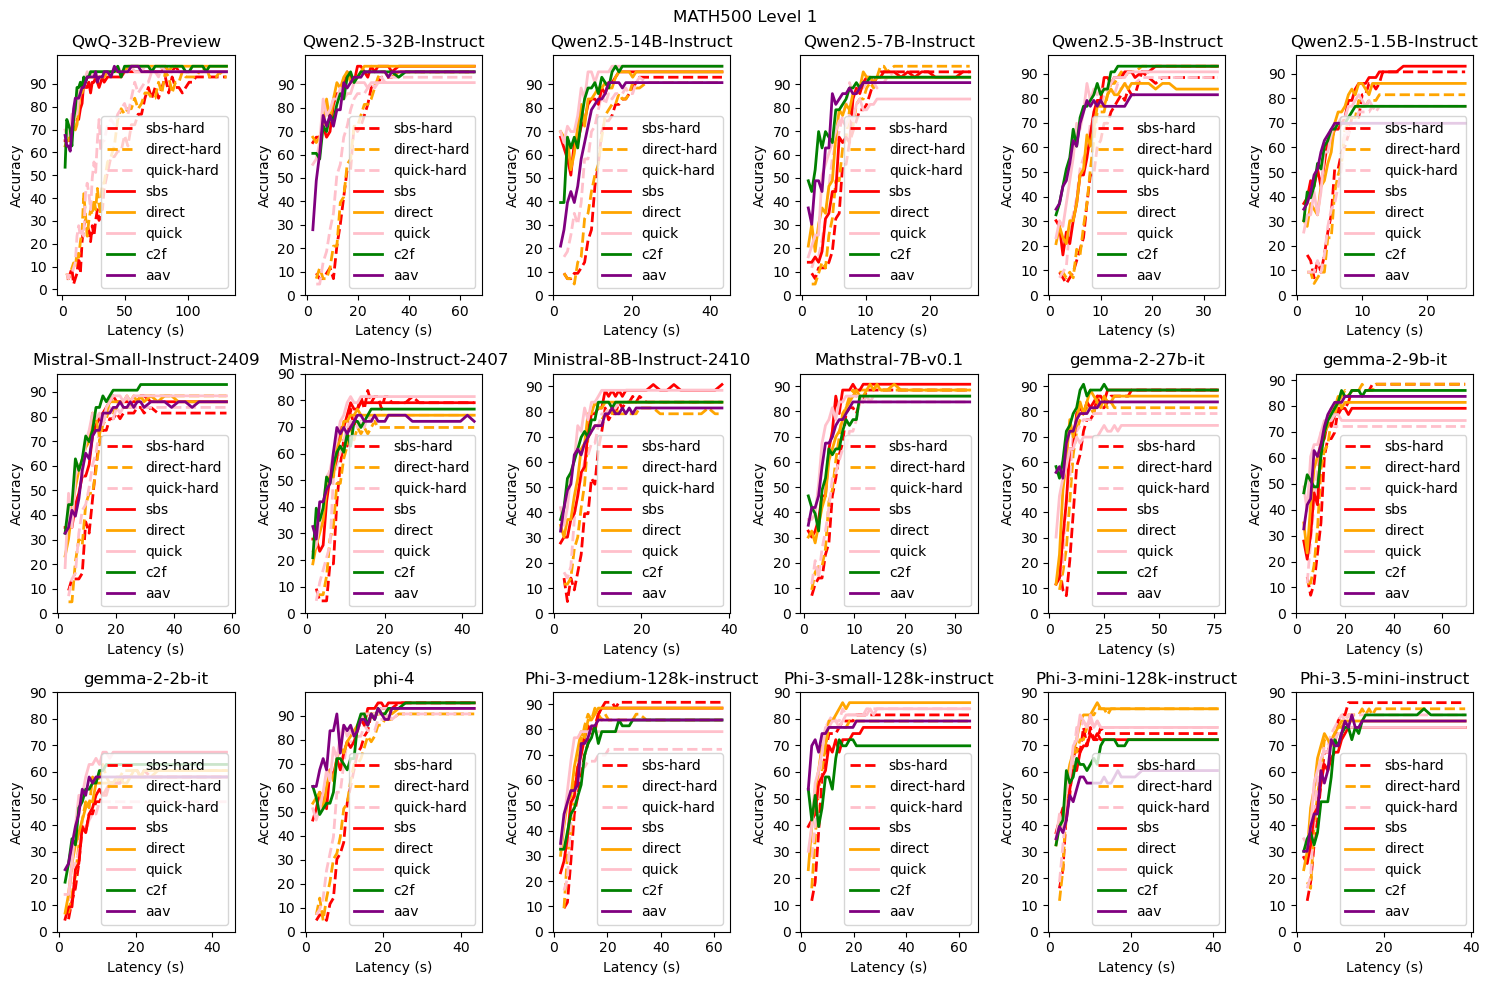

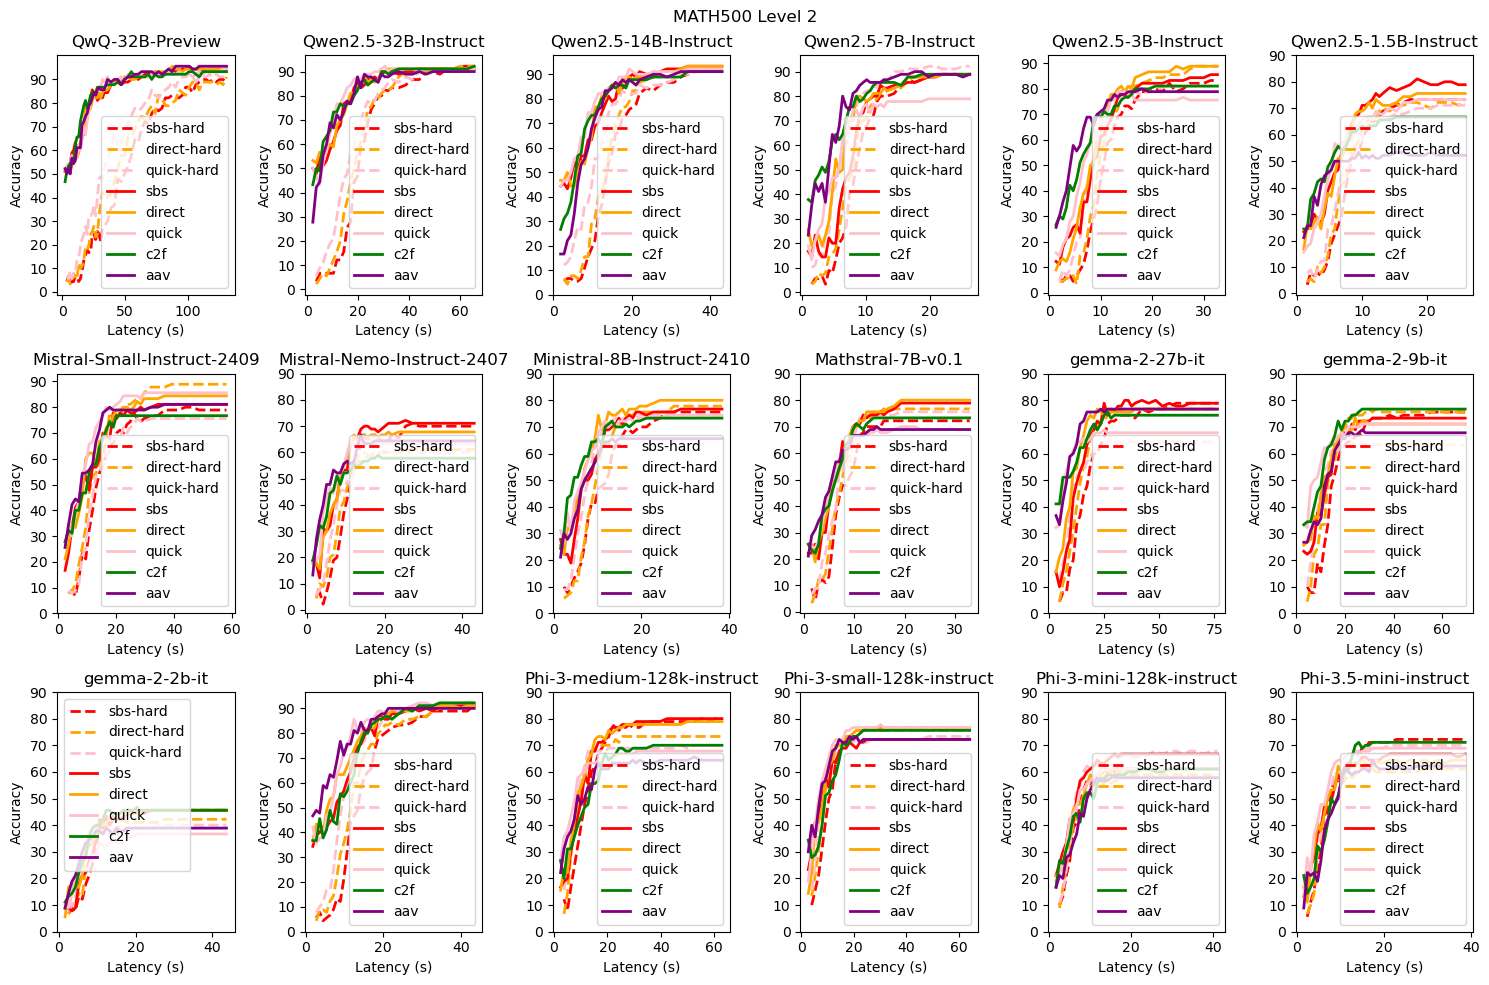

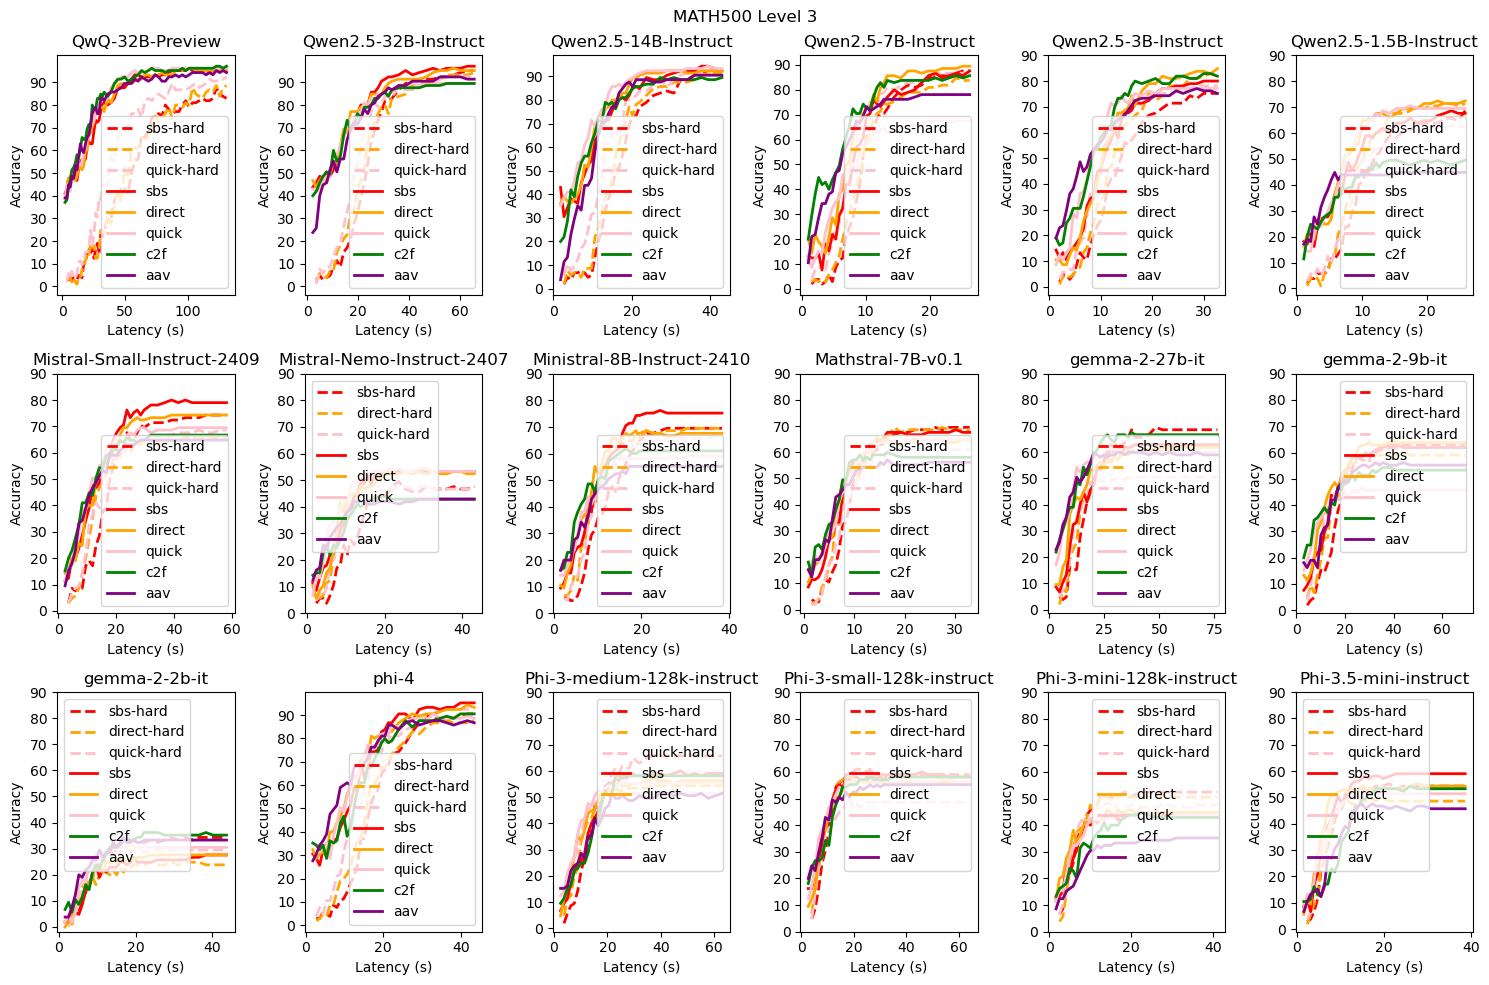

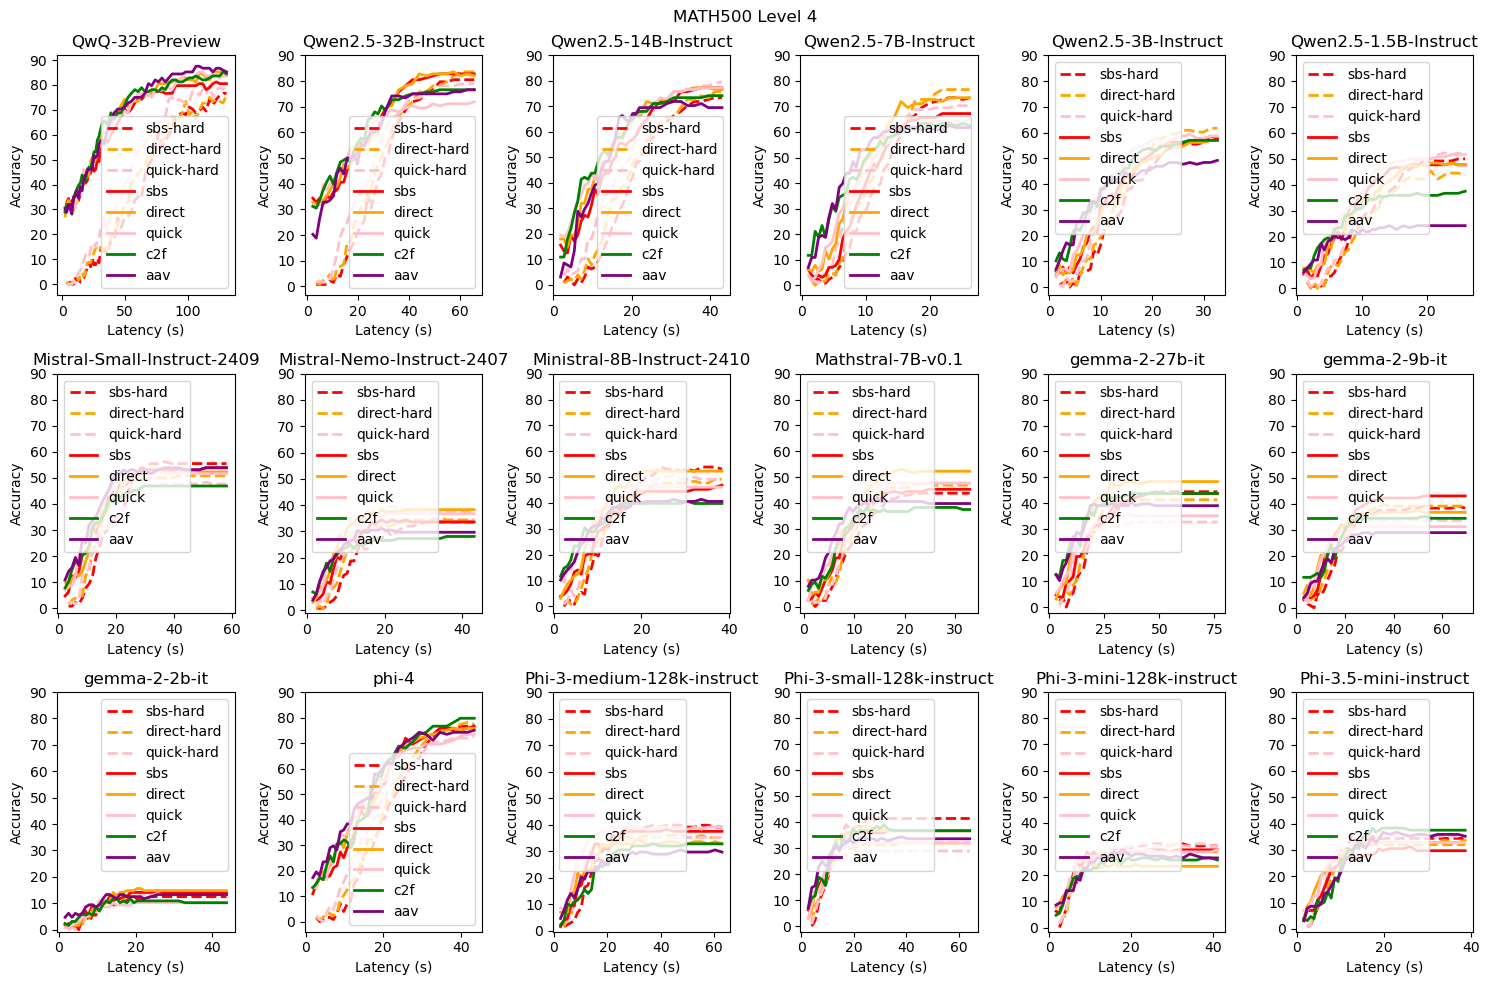

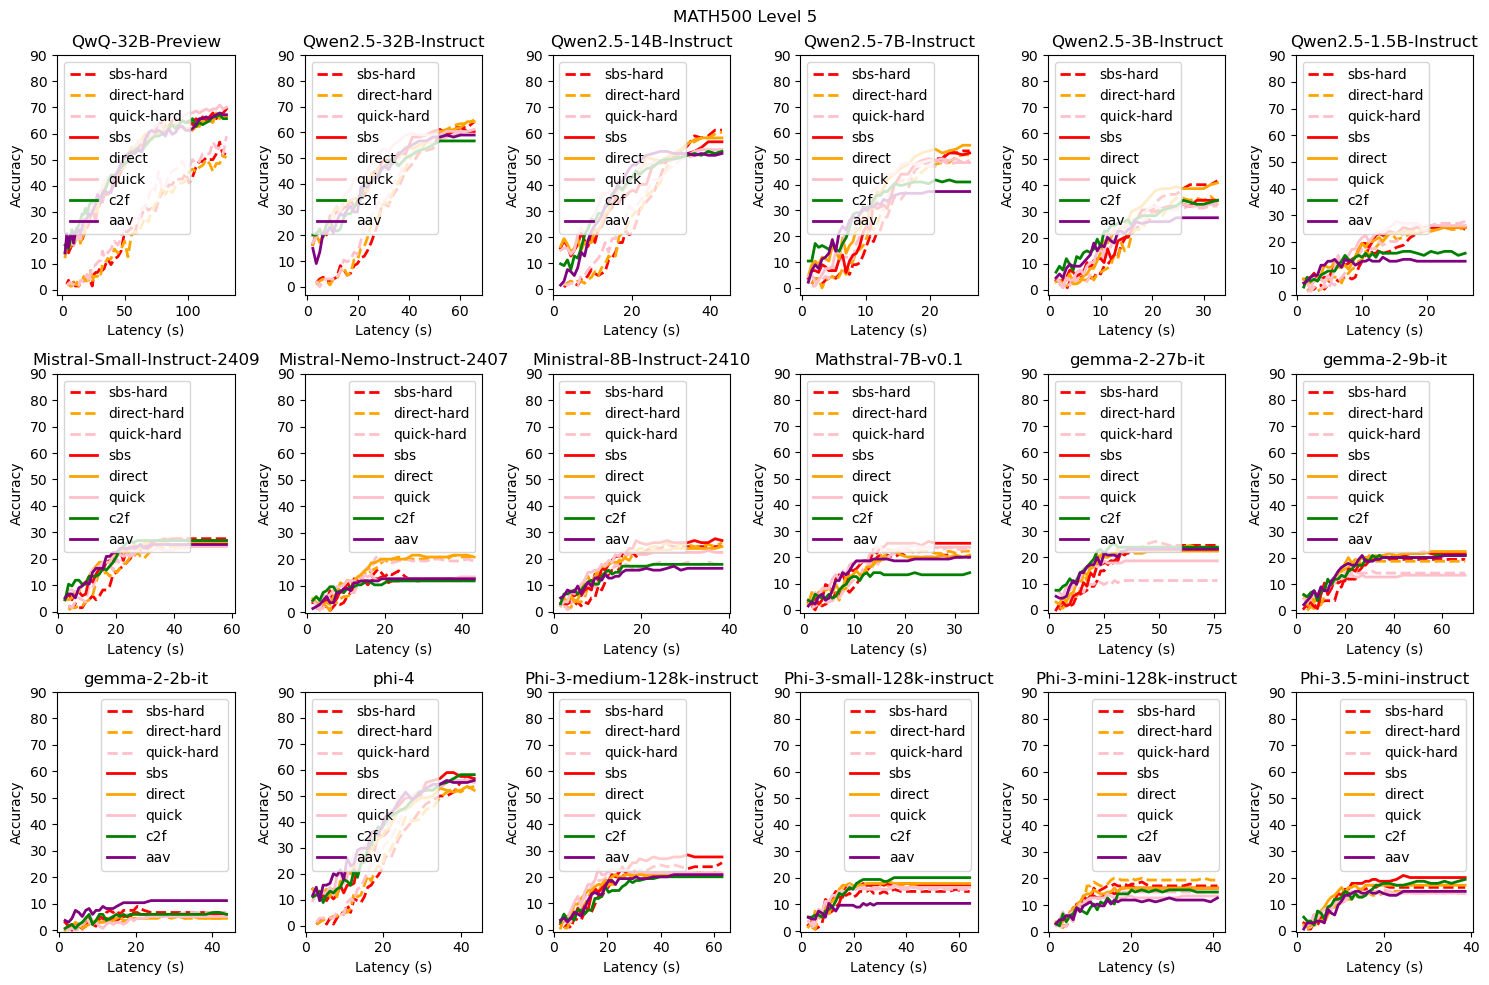

In [15]:
for level in range(1, 6):
    # Create subplots
    fig, axs = plt.subplots(3, 6, figsize=(15, 10))
    marker_size = 5  # Set the desired marker size
    line_width = 2   # Set the desired line width

    # Flatten the axes array for easy iteration
    axs = axs.flatten()

    for index, model in enumerate(model_list):
        model_prompt_list = MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]
        for prompt_type in model_prompt_list:
            if "sbs-hard" in prompt_type:
                axs[index].plot(model_latency_dicts[model][1:], [level_acc[str(level)] for level_acc in model_level_acc_dicts[model][prompt_type][1:]], linestyle='--', color="red", label="sbs-hard", linewidth=line_width)
            elif "direct-hard" in prompt_type:
                axs[index].plot(model_latency_dicts[model][1:], [level_acc[str(level)] for level_acc in model_level_acc_dicts[model][prompt_type][1:]], linestyle='--', color="orange", label="direct-hard", linewidth=line_width)
            elif "quick-hard" in prompt_type:
                axs[index].plot(model_latency_dicts[model][1:], [level_acc[str(level)] for level_acc in model_level_acc_dicts[model][prompt_type][1:]], linestyle='--', color="pink", label="quick-hard", linewidth=line_width)
            elif "sbs" in prompt_type:
                axs[index].plot(model_latency_dicts[model], [level_acc[str(level)] for level_acc in model_level_acc_dicts[model][prompt_type]], linestyle='-', color="red", label="sbs",
                linewidth=line_width)
            elif "direct" in prompt_type:
                axs[index].plot(model_latency_dicts[model], [level_acc[str(level)] for level_acc in model_level_acc_dicts[model][prompt_type]], linestyle='-', color="orange", label="direct", linewidth=line_width)
            elif "quick" in prompt_type:
                axs[index].plot(model_latency_dicts[model], [level_acc[str(level)] for level_acc in model_level_acc_dicts[model][prompt_type]], linestyle='-', color="pink", label="quick", linewidth=line_width)
            elif "c2f" in prompt_type:
                axs[index].plot(model_latency_dicts[model], [level_acc[str(level)] for level_acc in model_level_acc_dicts[model][prompt_type]], linestyle='-', color="green", label="c2f", linewidth=line_width)
            # elif "kf" in prompt_type:
            #     axs[index].plot(model_latency_dicts[model], [level_acc[str(level)] for level_acc in model_level_acc_dicts[model][prompt_type]], linestyle='-', color="blue", label="kf", linewidth=line_width)
            elif "aav" in prompt_type:
                axs[index].plot(model_latency_dicts[model], [level_acc[str(level)] for level_acc in model_level_acc_dicts[model][prompt_type]], linestyle='-', color="purple", label="aav", linewidth=line_width)
            axs[index].set_xlabel("Latency (s)")
            axs[index].set_ylabel("Accuracy")
            axs[index].set_title(f"{model.split('/')[-1]}")
            axs[index].legend()
            
            # Set y-axis and x-axis ticks
            axs[index].set_yticks(range(0, 91, 10))  # Set y-axis interval to 10
            # axs[index].set_xticks(range(0, 551, 50))  # Set x-axis interval to 50

    # set the title
    plt.suptitle(f"{dataset}".upper() + " Level " + str(level))
    # Adjust layout
    plt.tight_layout()
    plt.show()

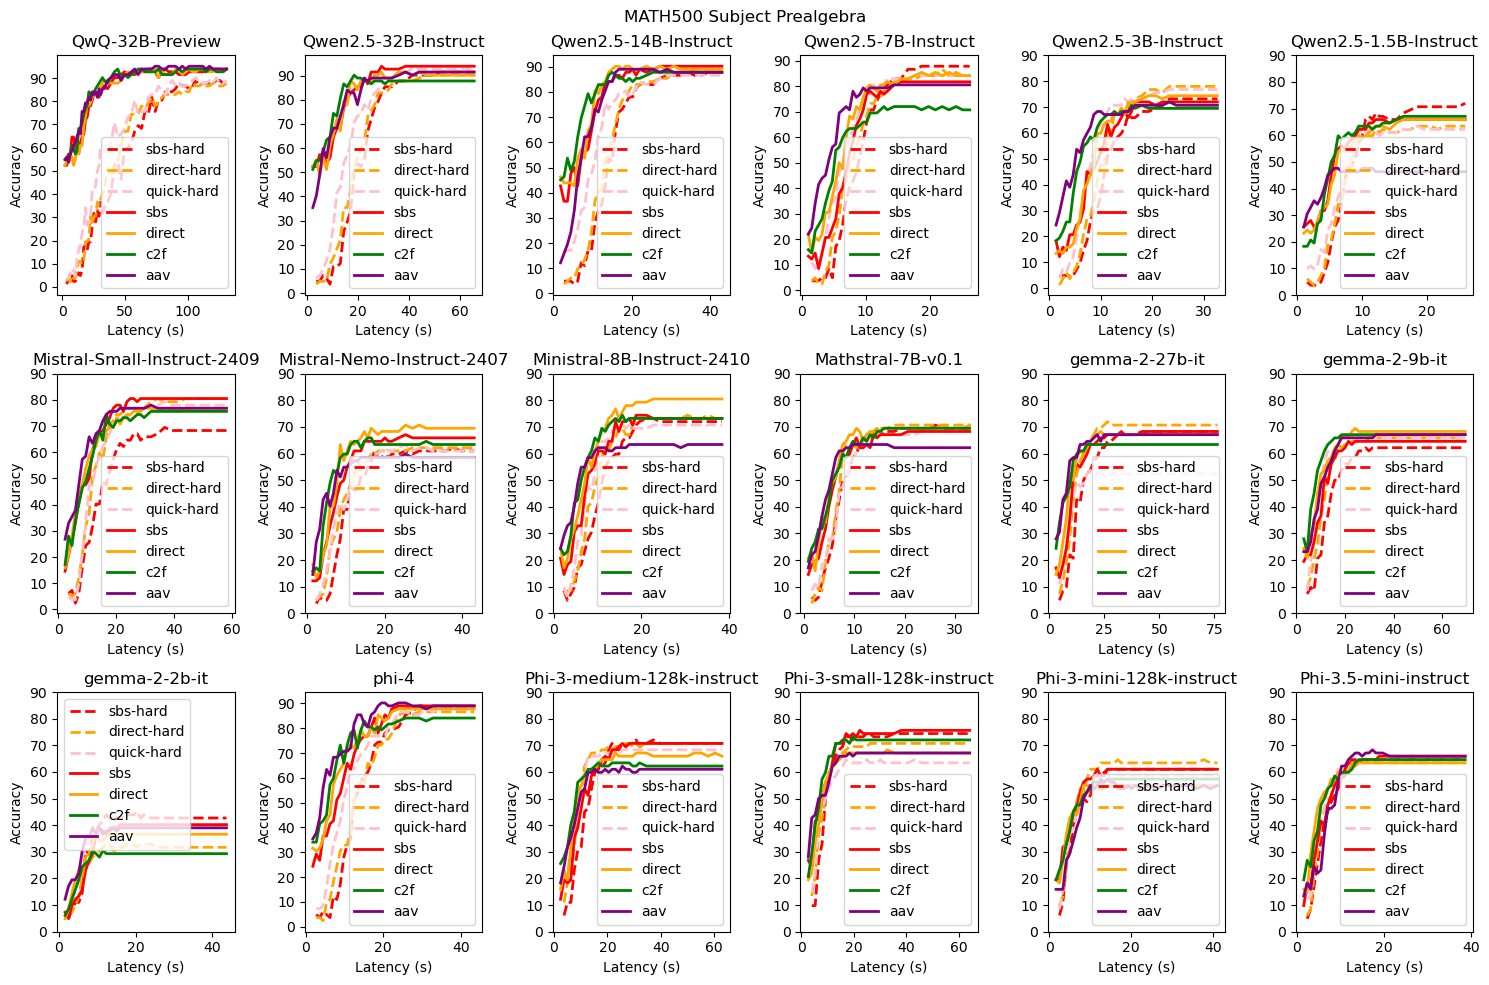

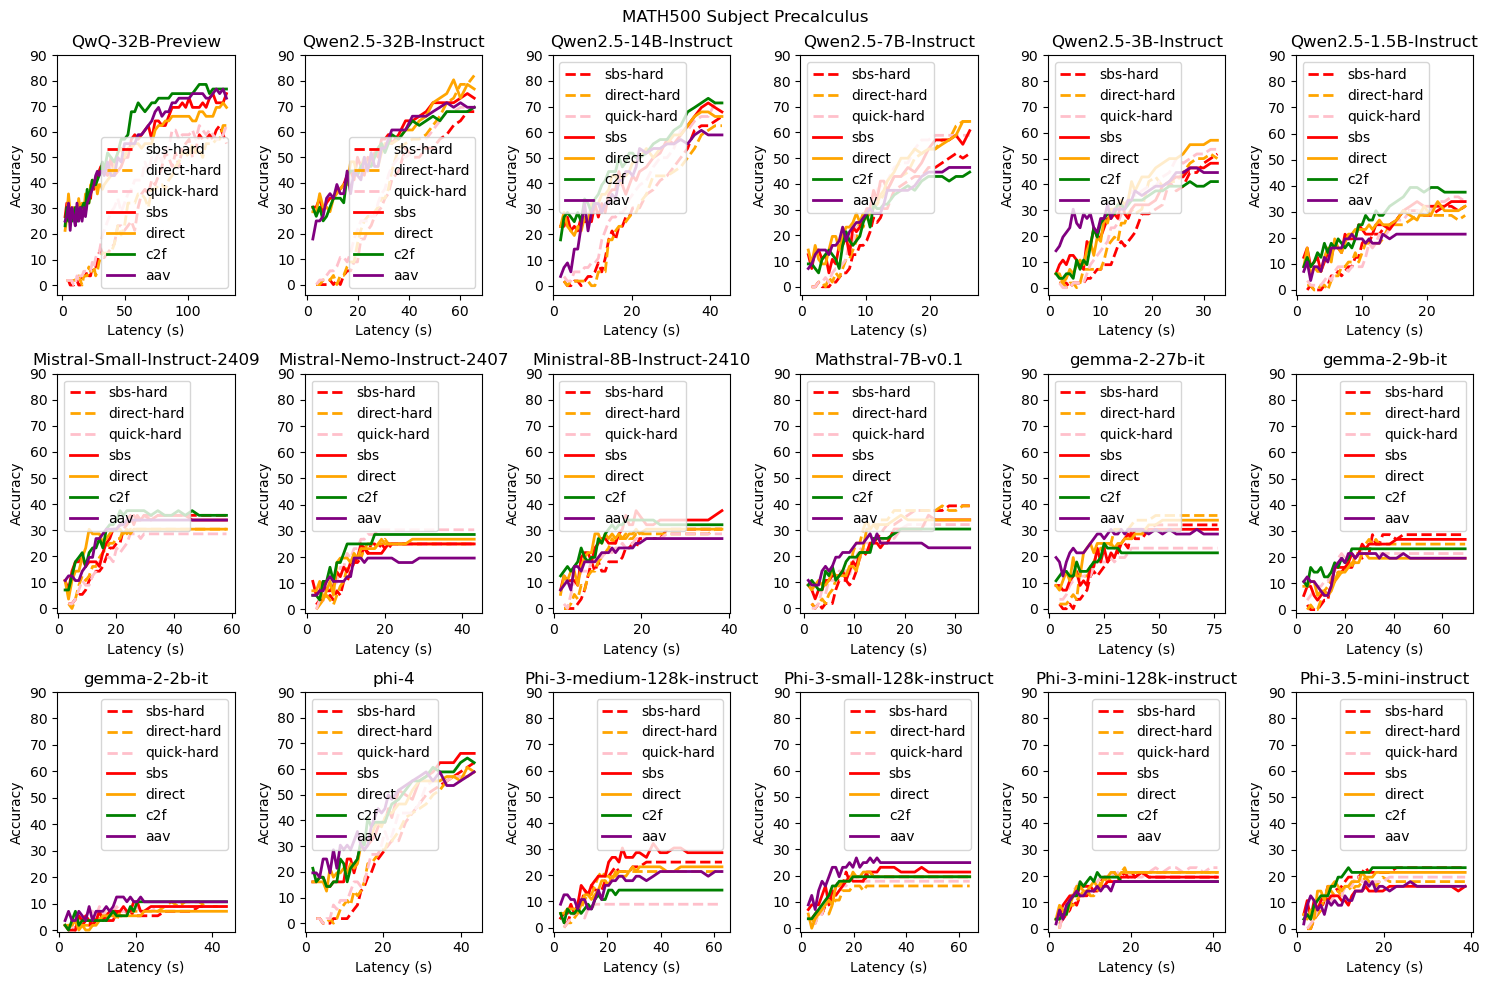

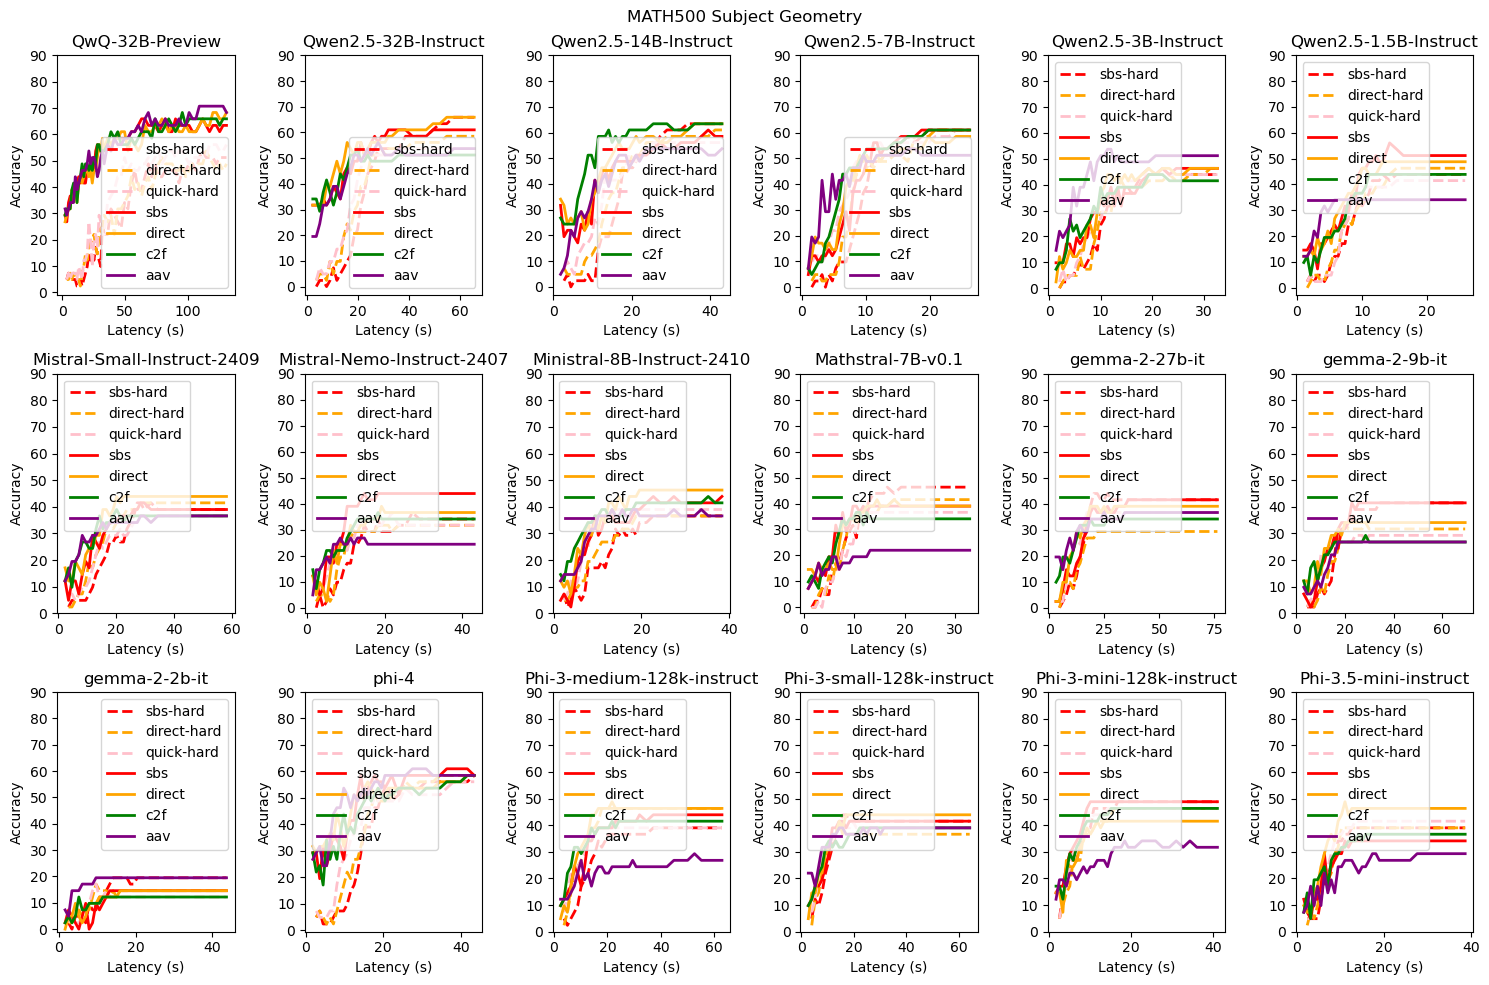

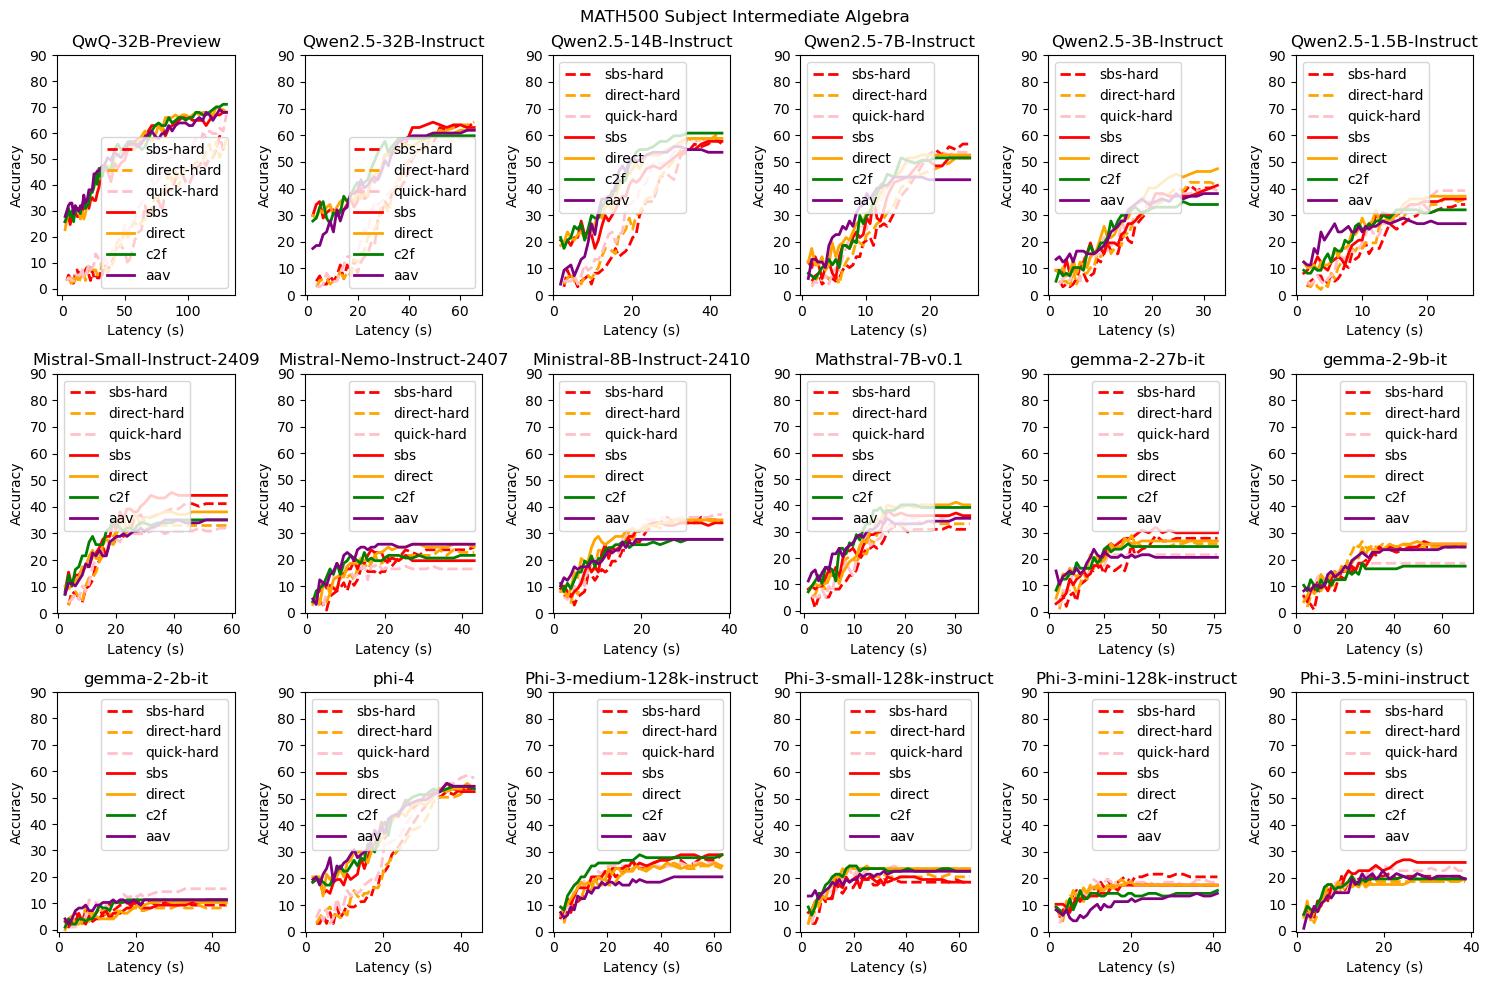

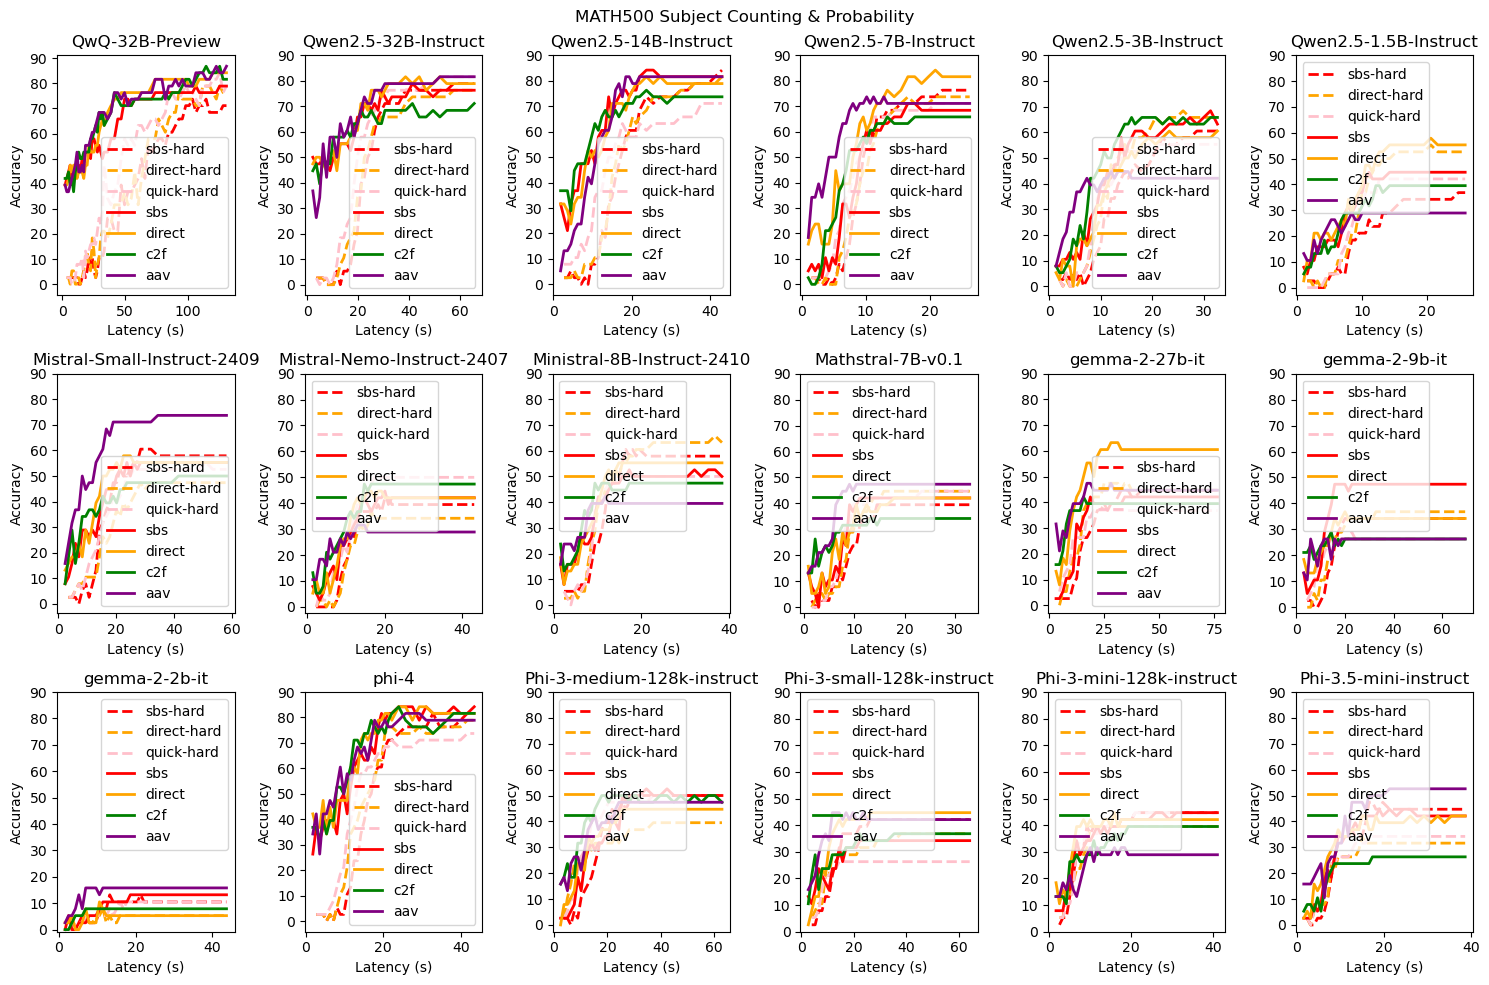

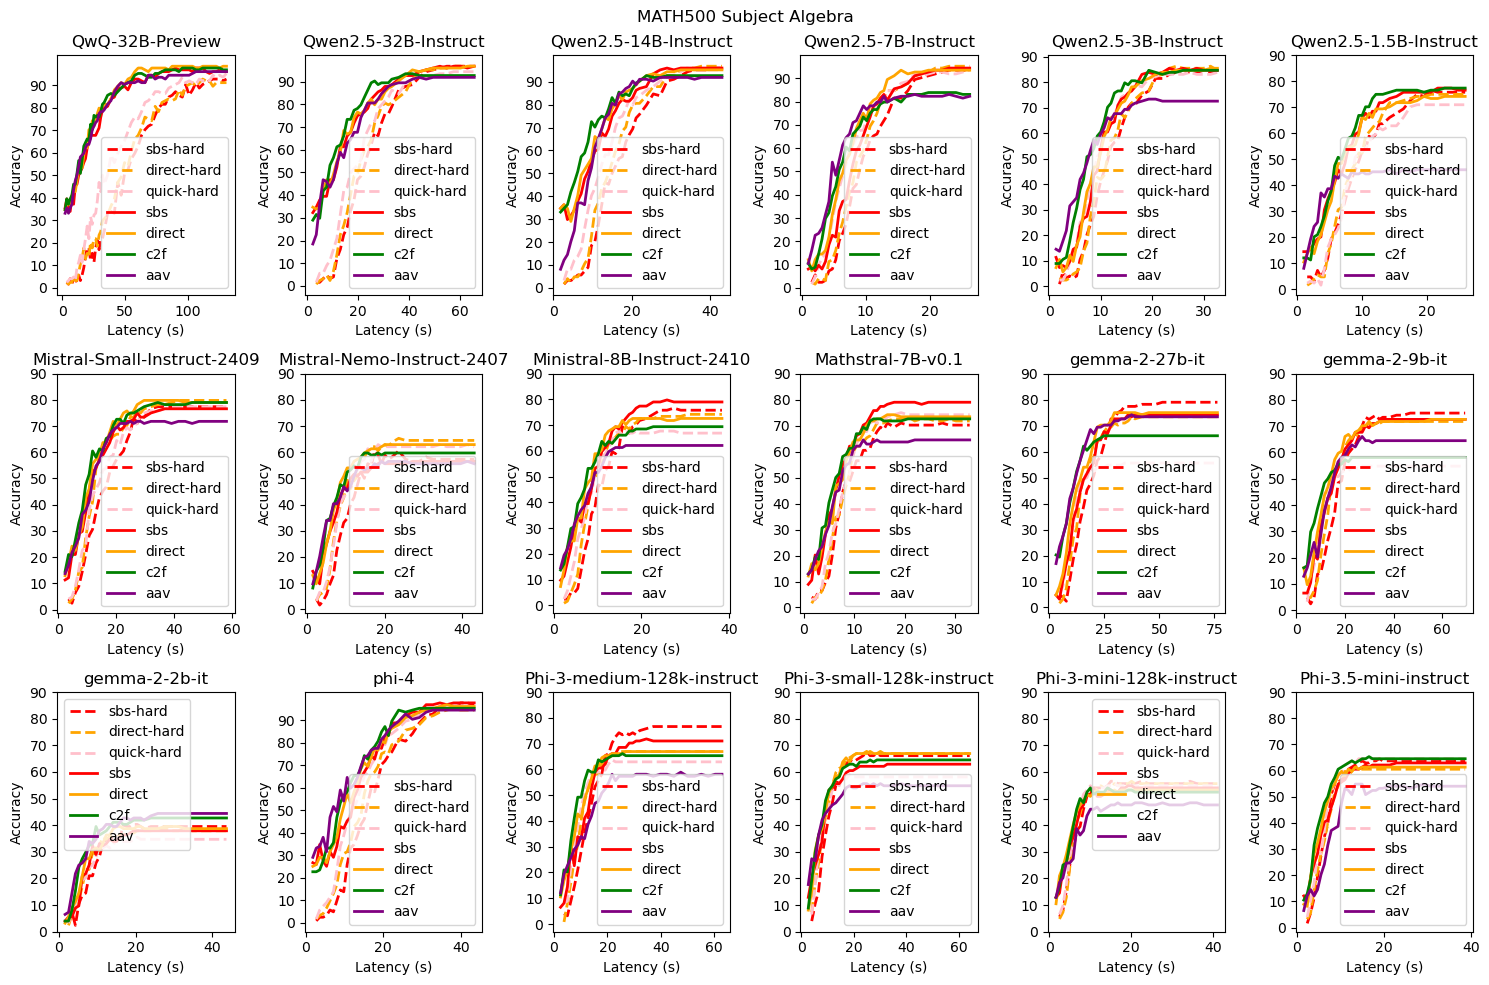

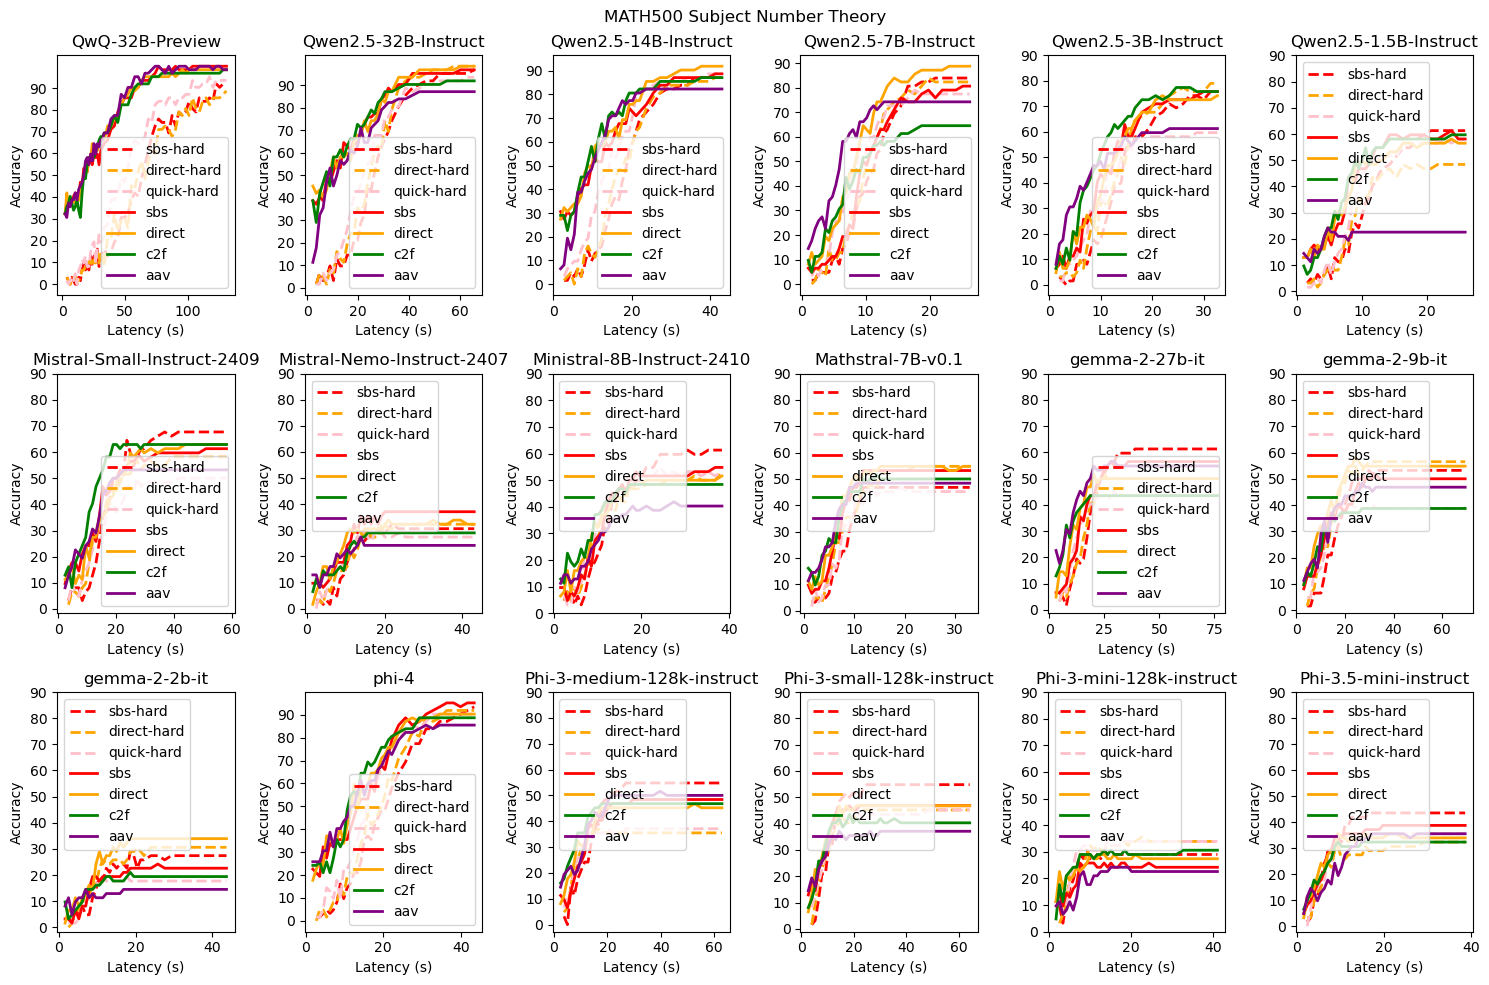

In [16]:
for subject in ["Prealgebra", "Precalculus", "Geometry", "Intermediate Algebra", "Counting & Probability", "Algebra", "Number Theory"]:
    # Create subplots
    fig, axs = plt.subplots(3, 6, figsize=(15, 10))
    marker_size = 5  # Set the desired marker size
    line_width = 2   # Set the desired line width

    # Flatten the axes array for easy iteration
    axs = axs.flatten()

    for index, model in enumerate(model_list):
        model_prompt_list = MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]
        for prompt_type in model_prompt_list:
            if "sbs-hard" in prompt_type:
                axs[index].plot(model_latency_dicts[model][1:], [subject_acc[subject] for subject_acc in model_subject_acc_dicts[model][prompt_type][1:]], linestyle='--', color="red", label="sbs-hard", linewidth=line_width)
            elif "direct-hard" in prompt_type:
                axs[index].plot(model_latency_dicts[model][1:], [subject_acc[subject] for subject_acc in model_subject_acc_dicts[model][prompt_type][1:]], linestyle='--', color="orange", label="direct-hard", linewidth=line_width)
            elif "quick-hard" in prompt_type:
                axs[index].plot(model_latency_dicts[model][1:], [subject_acc[subject] for subject_acc in model_subject_acc_dicts[model][prompt_type][1:]], linestyle='--', color="pink", label="quick-hard", linewidth=line_width)
            elif "sbs" in prompt_type:
                axs[index].plot(model_latency_dicts[model], [subject_acc[subject] for subject_acc in model_subject_acc_dicts[model][prompt_type]], linestyle='-', color="red", label="sbs",
                linewidth=line_width)
            elif "direct" in prompt_type:
                axs[index].plot(model_latency_dicts[model], [subject_acc[subject] for subject_acc in model_subject_acc_dicts[model][prompt_type]], linestyle='-', color="orange", label="direct", linewidth=line_width)
            elif "quick" in prompt_type:
                axs[index].plot(model_latency_dicts[model], [subject_acc[subject] for subject_acc in model_subject_acc_dicts[model][prompt_type]], linestyle='-', color="green", label="c2f", linewidth=line_width)
            # elif "kf" in prompt_type:
            #     axs[index].plot(model_latency_dicts[model], [subject_acc[subject] for subject_acc in model_subject_acc_dicts[model][prompt_type]], linestyle='-', color="blue", label="kf", linewidth=line_width)
            elif "aav" in prompt_type:
                axs[index].plot(model_latency_dicts[model], [subject_acc[subject] for subject_acc in model_subject_acc_dicts[model][prompt_type]], linestyle='-', color="purple", label="aav", linewidth=line_width)
            axs[index].set_xlabel("Latency (s)")
            axs[index].set_ylabel("Accuracy")
            axs[index].set_title(f"{model.split('/')[-1]}")
            axs[index].legend()
            
            # Set y-axis and x-axis ticks
            axs[index].set_yticks(range(0, 91, 10))  # Set y-axis interval to 10
            # axs[index].set_xticks(range(0, 551, 50))  # Set x-axis interval to 50

    # set the title
    plt.suptitle(f"{dataset}".upper() + " Subject " + subject)
    # Adjust layout
    plt.tight_layout()
    plt.show()